In [1]:
!pip install pystan
!pip install fbprophet

In [2]:

#Importing libraries
import numpy as np 
from scipy.stats import randint
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
%matplotlib inline
import matplotlib as mpl
from fbprophet import Prophet

In [3]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
ls'/content/gdrive/My Drive/Thesis'

dataframe_dma_flow_1D.csv     dataframe_flow_variable_1D.csv     DMA_468.csv
dataframe_dma_flow_60min.csv  dataframe_flow_variable_60min.csv
dataframe_flow_1D.csv         DMA_225.csv


In [5]:
data = pd.read_csv("/content/gdrive/My Drive/Thesis/dataframe_flow_variable_60min.csv")
data['Unnamed: 0'] = pd.to_datetime(data['Unnamed: 0'])
data.rename( columns={'Unnamed: 0':'Date_time','225':'DMA_225'}, inplace=True )

In [6]:

data_DMA225 = data[['Date_time','DMA_225','tempC','HeatIndexC','FeelsLikeC','WindChillC','windspeedKmph','sunHour','precipMM','humidity']]

In [7]:
data_DMA225_indexed = data_DMA225.set_index('Date_time')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f5cfde25550>,
      dtype=object)

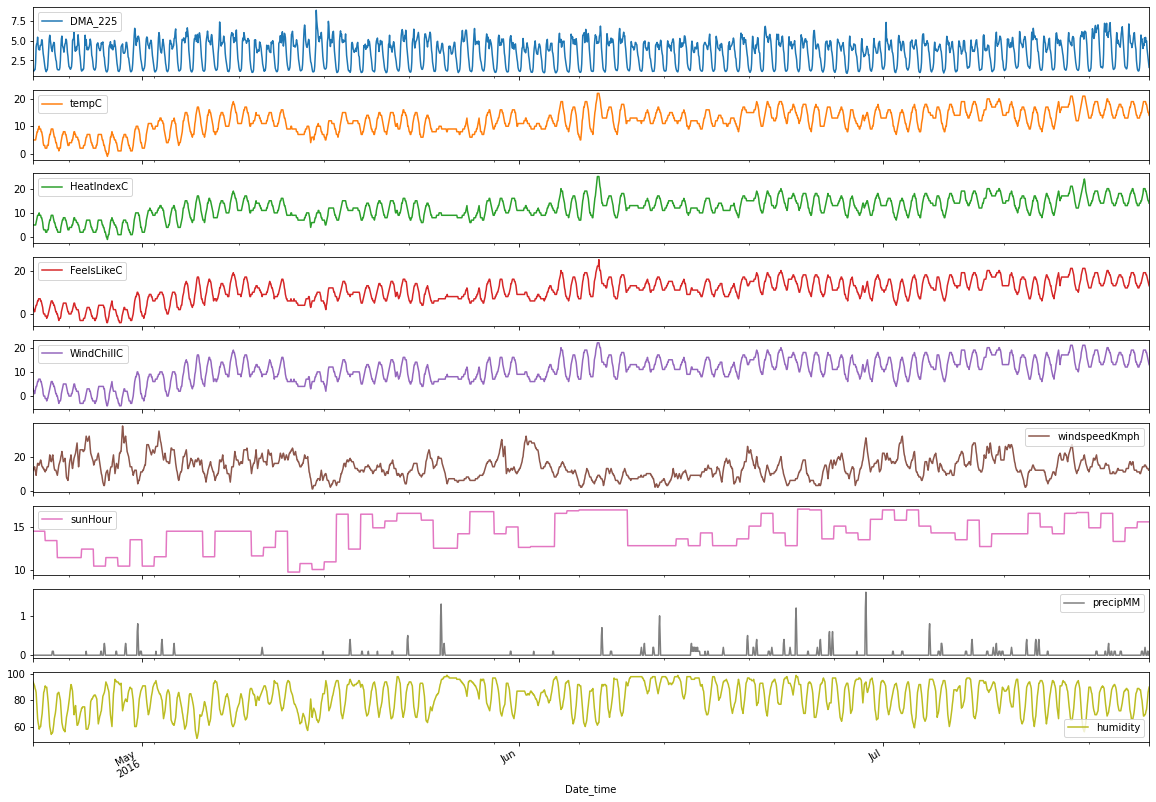

In [8]:
mpl.rcParams['figure.figsize'] = (20, 15)
mpl.rcParams['axes.grid'] = False

data_DMA225_indexed[['DMA_225','tempC','HeatIndexC','FeelsLikeC','WindChillC','windspeedKmph','sunHour','precipMM','humidity']].plot(subplots=True)

In [9]:
#Statistical information
data_DMA225_indexed.describe()

,DMA_225,tempC,HeatIndexC,FeelsLikeC,WindChillC,windspeedKmph,sunHour,precipMM,humidity
count,2208.000000,2208.000000,2208.000000,2208.000000,2208.000000,2208.000000,2208.000000,2208.000000,2208.000000
mean,3.562107,11.943388,12.059783,10.769475,10.768116,13.920290,14.180435,0.022509,82.723279
std,1.638267,4.128977,4.158292,5.100604,5.097210,6.153009,1.964704,0.100184,10.948533
min,0.861250,-1.000000,-1.000000,-4.000000,-4.000000,1.000000,9.700000,0.000000,51.000000
25%,1.805750,9.000000,9.000000,8.000000,8.000000,9.000000,12.800000,0.000000,74.000000
50%,3.972250,12.000000,12.000000,11.000000,11.000000,13.000000,14.300000,0.000000,85.000000
75%,4.833500,15.000000,15.000000,15.000000,15.000000,18.000000,15.800000,0.000000,92.000000
max,8.916750,22.000000,25.000000,25.000000,22.000000,38.000000,17.100000,1.600000,99.000000


In [10]:
#general Information
data_DMA225_indexed.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2208 entries, 2016-04-22 00:00:00 to 2016-07-22 23:00:00
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DMA_225        2208 non-null   float64
 1   tempC          2208 non-null   int64  
 2   HeatIndexC     2208 non-null   int64  
 3   FeelsLikeC     2208 non-null   int64  
 4   WindChillC     2208 non-null   int64  
 5   windspeedKmph  2208 non-null   int64  
 6   sunHour        2208 non-null   float64
 7   precipMM       2208 non-null   float64
 8   humidity       2208 non-null   int64  
dtypes: float64(3), int64(6)
memory usage: 172.5 KB


In [11]:
#Checking for null values
data_DMA225_indexed.isnull().sum()

DMA_225          0
tempC            0
HeatIndexC       0
FeelsLikeC       0
WindChillC       0
windspeedKmph    0
sunHour          0
precipMM         0
humidity         0
dtype: int64

In [12]:
# Making hourly data 
hourly_data = data_DMA225_indexed.resample('h').sum()

In [13]:
#Resetting index
hourly_data_index = hourly_data.reset_index()
#Renaming columns
hourly_data_index = hourly_data_index.rename(columns= {'Date_time': 'ds', 'DMA_225':'y'})
hourly_data_index.shape

(2208, 10)

In [14]:
#Train and test split
step_out = 24
train = hourly_data_index[:len(hourly_data_index)-step_out]
test = hourly_data_index[len(hourly_data_index)-step_out:]

In [15]:
train.shape

(2184, 10)

In [16]:
test.shape

(24, 10)

In [17]:
test.columns

Index(['ds', 'y', 'tempC', 'HeatIndexC', 'FeelsLikeC', 'WindChillC',
       'windspeedKmph', 'sunHour', 'precipMM', 'humidity'],
      dtype='object')

In [18]:
model = Prophet(changepoint_prior_scale=0.005,
               seasonality_prior_scale = 0.01) 
model.add_regressor('tempC')
model.add_regressor('HeatIndexC')
model.add_regressor('FeelsLikeC')
model.add_regressor('WindChillC')
model.add_regressor('windspeedKmph')
model.add_regressor('sunHour')
model.add_regressor('precipMM')
model.add_regressor('humidity')

model.fit(train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [19]:
test.shape[0]

24

In [26]:
# Forecast / Predict

future_prediction = model.make_future_dataframe(periods = test.shape[0], freq = '1H')  
forecast_prediction = model.predict(test)
forecast_prediction[['ds', 'yhat']]

,ds,yhat
0,2016-07-22 00:00:00,1.937130
1,2016-07-22 01:00:00,1.748476
2,2016-07-22 02:00:00,1.569010
3,2016-07-22 03:00:00,1.572244
4,2016-07-22 04:00:00,1.998895
5,2016-07-22 05:00:00,3.029656
6,2016-07-22 06:00:00,4.223024
7,2016-07-22 07:00:00,5.287856
8,2016-07-22 08:00:00,5.765099
9,2016-07-22 09:00:00,5.662318


In [21]:
dataList_test = list(test.y.values)

In [27]:
#Calculate rmse
from math import sqrt
from sklearn.metrics import mean_squared_error
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(dataList_test,forecast_prediction['yhat']))
rmse = round(rmse, 3)
print (" The root mean square vakue on testset: ",rmse)

 The root mean square vakue on testset:  0.565


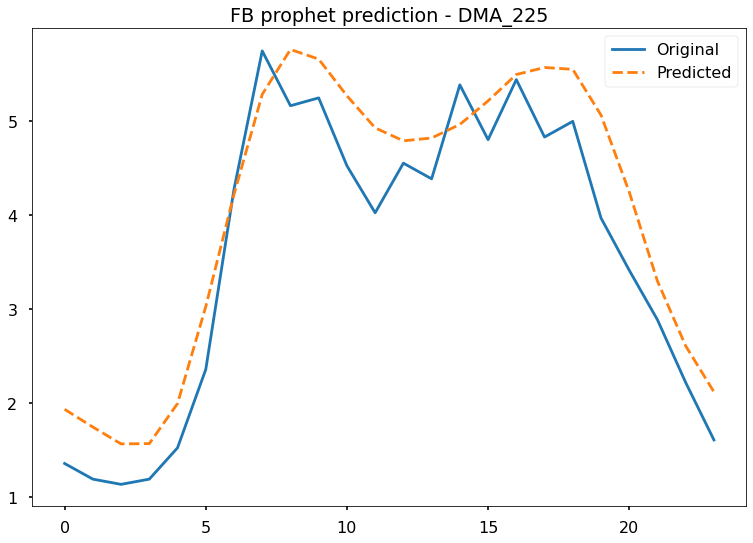

In [29]:
plt.style.use('seaborn-poster')
plt.figure()
plt.plot(dataList_test, label='Original')
plt.plot(forecast_prediction['yhat'].values, ls='--', label="Predicted")
plt.legend(loc='best')
plt.title('FB prophet prediction - DMA_225')
plt.show()